In [40]:
import pandas as pd
from wordcloud import WordCloud
df=pd.read_csv("/kaggle/input/dataset/Merged_data.csv")
# df.info()
# df.head()
# df.describe()

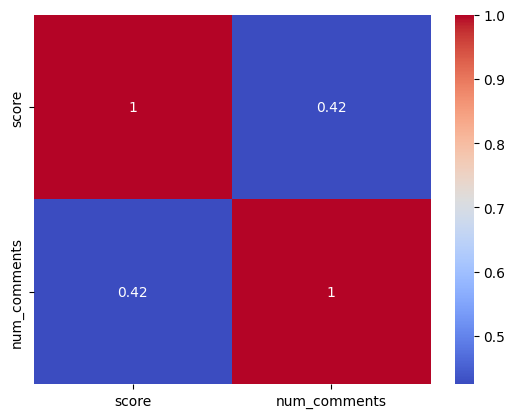

In [41]:
#more eda
import matplotlib.pyplot as plt
import seaborn as sns
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

# Heatmap visualization
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [42]:
df_with_image=df.dropna(subset=['image_url'])
df_without_image=df[df["image_url"].isna()].copy()                              
df_without_image=df_without_image.drop("image_url",axis=1)
# df_without_image.info()

In [43]:
def punctuation_removal(r):
    punc = '!()-[]{};:""\,<>./?@#$%^&*_~'''
    for ele in r:
        if ele in punc:
            r = r.replace(ele, "")
    return r

<>:2: SyntaxWarning: invalid escape sequence '\,'
<>:2: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_55/690756869.py:2: SyntaxWarning: invalid escape sequence '\,'
  punc = '!()-[]{};:""\,<>./?@#$%^&*_~'''


In [44]:
df_with_image_fe=df_with_image.copy()
df_without_image_fe=df_without_image.copy()     
df_with_image_fe['title']=df_with_image_fe['title'].apply(punctuation_removal)
df_with_image_fe['title']=df_with_image_fe['title'].apply(punctuation_removal)
df_without_image_fe['title']=df_without_image_fe['title'].apply(punctuation_removal)
df_with_image_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2101 entries, 7 to 5222
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     2101 non-null   object
 1   permalink     2101 non-null   object
 2   score         2101 non-null   int64 
 3   num_comments  2101 non-null   int64 
 4   title         2101 non-null   object
 5   body_text     381 non-null    object
 6   image_url     2101 non-null   object
dtypes: int64(2), object(5)
memory usage: 131.3+ KB


In [45]:
from textblob import TextBlob
import numpy as np

df_with_image_fe['body_text'] = df_with_image_fe['body_text'].fillna("")
df_without_image_fe['body_text'] = df_without_image_fe['body_text'].fillna("")

def create_features_columns(df):
    # Length features
    df['title_len'] = df['title'].apply(len)
    df['body_len'] = df['body_text'].apply(len)
    df['word_count'] = df['body_text'].apply(lambda x: len(str(x).split(' ')))
    
    # Sentiment Analysis
    df['sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    return df

df_with_image_fe = create_features_columns(df_with_image_fe)
df_without_image_fe = create_features_columns(df_without_image_fe)

sub_stats = df.groupby('subreddit').agg({
    'score': 'mean',
    'num_comments': 'mean'
}).rename(columns={'score': 'sub_avg_score', 'num_comments': 'sub_avg_comm'})

df_with_image_fe = df_with_image_fe.merge(sub_stats, on='subreddit', how='left')
df_without_image_fe = df_without_image_fe.merge(sub_stats, on='subreddit', how='left')

def add_engagement_hooks(df_fe):

    df_fe['is_question'] = df_fe['title'].str.strip().str.endswith('?').astype(int)
    df_fe['sentiment_intensity'] = df_fe['sentiment'].abs()
    return df_fe

df_with_image_fe = add_engagement_hooks(df_with_image_fe)
df_without_image_fe = add_engagement_hooks(df_without_image_fe)

In [46]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_text_embeddings(texts):

    texts = [str(t) if pd.notnull(t) else "" for t in texts]
    
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

print("Encoding Titles (With Images)...")
title_emb_with_img = get_text_embeddings(df_with_image_fe['title'])

print("Encoding Body Text (With Images)...")
body_emb_with_img = get_text_embeddings(df_with_image_fe['body_text'])

print("Encoding Titles (Without Images)...")
title_emb_no_img = get_text_embeddings(df_without_image_fe['title'])

print("Encoding Body Text (Without Images)...")
body_emb_no_img = get_text_embeddings(df_without_image_fe['body_text'])

print(f"Title Embeddings Shape: {title_emb_with_img.shape}")

Encoding Titles (With Images)...


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Encoding Body Text (With Images)...


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Encoding Titles (Without Images)...


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Encoding Body Text (Without Images)...


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Title Embeddings Shape: (2101, 384)


In [47]:
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests
from io import BytesIO
import numpy as np


img_model = SentenceTransformer('clip-ViT-B-32')

def get_image_embeddings(image_urls):
 
    embeddings = []
    
    from tqdm.notebook import tqdm
    for url in tqdm(image_urls):
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content))
            
            emb = img_model.encode(img, show_progress_bar=False)
            embeddings.append(emb)
            
        except Exception as e:
            embeddings.append(np.zeros(512))
            
    return np.array(embeddings)


print("Downloading and processing images... This may take a while.")
image_embeddings = get_image_embeddings(df_with_image_fe['image_url'])

print(f"Image Embeddings Shape: {image_embeddings.shape}")

  0%|          | 0/2101 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (174662656 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (121484484 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (117331669 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image Embeddings Shape: (2101, 512)


In [48]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

all_subreddits = pd.concat([df_with_image_fe['subreddit'], df_without_image_fe['subreddit']]).to_frame()
ohe.fit(all_subreddits)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [49]:
def build_feature_matrix(df, title_emb, body_emb, img_emb=None):

    num_cols = [
        'sentiment', 'word_count', 'title_len', 'body_len', 
        'sub_avg_score', 'sub_avg_comm', 'is_question', 'sentiment_intensity'
    ]
    numerical_features = df[num_cols].values
    
    # Subreddit encoding
    subreddit_features = ohe.transform(df[['subreddit']])
    
    # Combine all parts
    features_list = [title_emb, body_emb, numerical_features, subreddit_features]
    
    if img_emb is not None:
        features_list.append(img_emb)
        
    return np.hstack(features_list)

print("Building X_with_image...")
X_with_image = build_feature_matrix(
    df_with_image_fe, 
    title_emb_with_img, 
    body_emb_with_img, 
    image_embeddings
)

print("Building X_without_image...")
X_without_image = build_feature_matrix(
    df_without_image_fe, 
    title_emb_no_img, 
    body_emb_no_img
)

y_score_with_img = df_with_image_fe['score'].values
y_comm_with_img = df_with_image_fe['num_comments'].values
y_score_no_img = df_without_image_fe['score'].values
y_comm_no_img = df_without_image_fe['num_comments'].values

Building X_with_image...
Building X_without_image...


Detected Image Embedding Size: 512
Merging datasets into X_unified...
Final Unified X Shape: (5223, 1339)
Final Unified y (Score) Shape: (5223,)
>>> Training Score Model...

TRAINING UNIFIED MODEL: Target: SCORE (Combined Dataset)


[16:34:03] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



R2 Score: 0.9117
MAE:      7682.1927
MSE:      268448452.0716


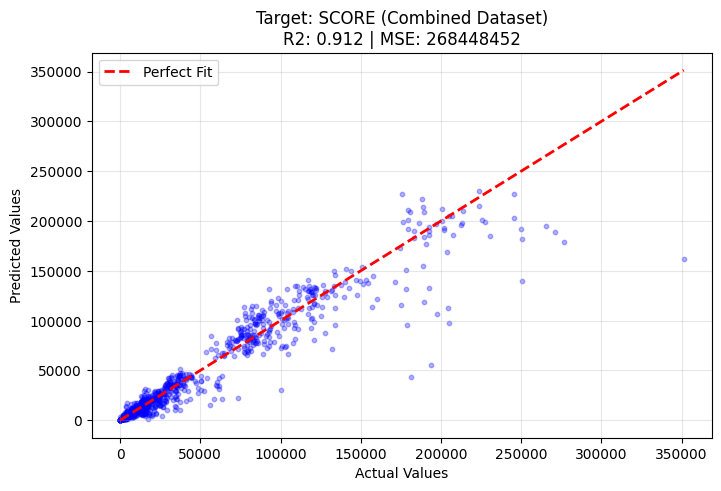


>>> Training Comments Model...

TRAINING UNIFIED MODEL: Target: COMMENTS (Combined Dataset)


[16:39:38] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



R2 Score: 0.3562
MAE:      1170.2882
MSE:      16365906.7812


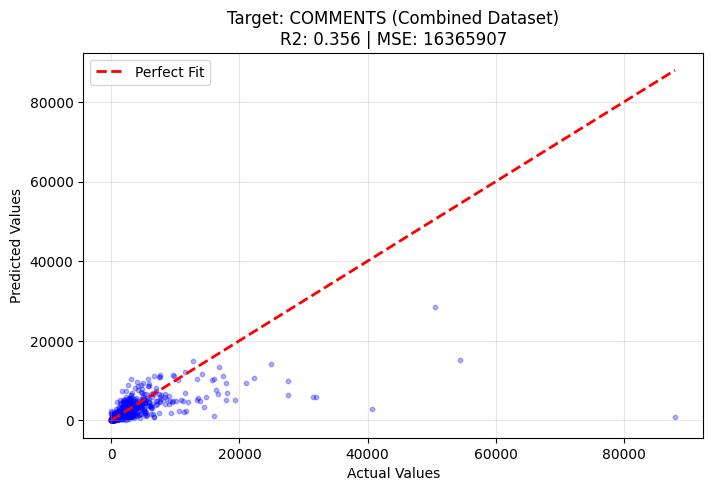

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor

# --- 1. COMBINING DATASETS (Merge "With Image" and "Without Image") ---


img_emb_size = X_with_image.shape[1] - X_without_image.shape[1]

print(f"Detected Image Embedding Size: {img_emb_size}")

# Create np.zeroes for rows where there is no image

zero_padding = np.zeros((X_without_image.shape[0], img_emb_size))

X_without_image_padded = np.hstack([X_without_image, zero_padding])

# Vertically stack both datasets into one "Unified" dataset
print("Merging datasets into X_unified...")
X_unified = np.vstack([X_with_image, X_without_image_padded])

y_score_unified = np.concatenate([y_score_with_img, y_score_no_img])
y_comm_unified = np.concatenate([y_comm_with_img, y_comm_no_img])

print(f"Final Unified X Shape: {X_unified.shape}")
print(f"Final Unified y (Score) Shape: {y_score_unified.shape}")


def build_fast_stack():
    base_models = [
        ('hgb', HistGradientBoostingRegressor(
            max_iter=1000, 
            learning_rate=0.1, 
            l2_regularization=1.5,
            random_state=42
        )),
        ('xgb', XGBRegressor(
            tree_method='hist', 
            device='cuda',        # Using GPU
            n_estimators=800, 
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ))
    ]
    
    stack = StackingRegressor(
        estimators=base_models,
        final_estimator=RidgeCV(),
        cv=3,
        n_jobs=-1
    )
    
    # Target Transformation (Log1p) is required for Reddit scores
    return TransformedTargetRegressor(
        regressor=stack,
        func=np.log1p,
        inverse_func=np.expm1
    )



def train_and_evaluate(X, y, task_name):
    print(f"\n{'='*50}")
    print(f"TRAINING UNIFIED MODEL: {task_name}")
    print(f"{'='*50}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = build_fast_stack()
    model.fit(X_train, y_train)
    
    
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds) # MSE added as requested
    
    # PRINT RESULTS
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE:      {mae:.4f}")
    print(f"MSE:      {mse:.4f}")
    
    # Visualize
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, preds, alpha=0.3, s=10, color='blue')
    
    # Draw Perfect Fit Line
    min_val, max_val = y_test.min(), y_test.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
    
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{task_name}\nR2: {r2:.3f} | MSE: {mse:.0f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return model



print(">>> Training Score Model...")
model_score = train_and_evaluate(
    X_unified, 
    y_score_unified, 
    "Target: SCORE (Combined Dataset)"
)

print("\n>>> Training Comments Model...")
model_comments = train_and_evaluate(
    X_unified, 
    y_comm_unified, 
    "Target: COMMENTS (Combined Dataset)"
)